In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import skrf as rf
from skrf.media import cpw
from scipy.constants import electron_mass as m_e, elementary_charge as q_e
from tqdm.notebook import tqdm
from alive_progress import alive_bar
import warnings 

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'Arial'

from matplotlib.collections import LineCollection
from ipywidgets import interact, widgets

%matplotlib inline
%config InlineBackend.figure_format='retina'

from quantum_electron import package_versions
package_versions()

quantum_electron 0.2.2
numpy 1.25.2
scipy 1.9.3
matplotlib 3.5.3


The goal of this notebook is to study the circuit model for a transmission line and its coupling to electrons on helium. This model is slightly more advanced than the model studied in https://arxiv.org/pdf/2410.19592. 

The overarching approach is to break up the transmission line into unit cells with a capacitance $C$ to ground and series inductance $L$. First, we study a simple transmission line, then modify the boundary conditions to have the tips of a CPW meet each other. Finally, the coupling to electrons on helium is introduced in the final section

1. [Simple transmission line](#section_0)
2. [Transmission line with shunt capacitance](#section_1)
3. [Meandering resonator with shunt capacitances](#section_2)
4. [Periodic transmission line with a break](#section_3)

# Simple transmission line <a class="anchor" id="section_0"></a>

We start with a simple transmission line, which has a unit cell containing an inductor $L$ in series and a capacitance $C$ to ground. We write down the Lagrangian, carefully keeping track of any terms involving node $n$:
$$
    \mathcal{L} = \frac{1}{2} C \dot{\phi}_n^2 - \frac{1}{2L} \left( \phi_{n+1} - \phi_{n} \right)^2 - \frac{1}{2L} \left( \phi_{n} - \phi_{n-1} \right)^2 + \ldots
$$
The dots capture other terms that do not involve node $n$, which we can neglect due to translational symmetry of the transmission line. We further note that the capacitance $C$ and inductance $L$ are per unit cell. Therefore, if the unit cell spans a length $\Delta x$, we may write $C = C_\ell \Delta x$ and $L = L_\ell \Delta x$, where $C_\ell$ ($L_\ell$) are the capacitance and inductance per unit length, respectively.

Next, we derive the equations of motion from the Lagrange equations, which yields
$$
    C \ddot{\phi}_n + \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right) = 0.
$$

This yields the following matrix equation
$$
    \omega^2 C \phi_n = \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right), 
$$
which can also be written as $\omega^2 \vec{\phi} = [\mathbf{M}]^{-1} [\mathbf{K}] \vec{\phi}$. Therefore, we have reduced the problem to finding the eigenvalues and eigenvectors of the matrix $[\mathbf{M}]^{-1} [\mathbf{K}]$
$$
    [\mathbf{M}] = C \begin{pmatrix}
        1 & 0 & 0 &\dots \\
        0 & 1 & 0 & \dots \\
        0 & 0 & 1 & \dots \\
        \vdots & \vdots & \vdots & \ddots
    \end{pmatrix}
$$

$$
    [\mathbf{K}] = \frac{1}{L} \begin{pmatrix}
        2 & -1 & 0 &\dots \\
        -1 & 2 & -1 & \dots \\
        0 & -1 & 2 & \ddots \\
        \vdots & \vdots & \ddots & \ddots
    \end{pmatrix}
$$

In [2]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1), quarter_λ=True)
def update(dx_um=25, total_length_mm=2, L_total_nH=100, C_total_fF=33, quarter_λ=False):
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    L_l = 1e-9 * L_total_nH / unit_cells
    C_l = 1e-15 * C_total_fF / unit_cells

    K = 1 / L_l * (np.diag(-1 * np.ones(unit_cells-1), k=-1) + np.diag(2 * np.ones(unit_cells), k=0) + np.diag(-1 * np.ones(unit_cells-1), k=1))

    if quarter_λ:
        K[-1, -1] = 1 / L_l
    
    M = C_l * np.diag(np.ones(unit_cells), k=0)

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    fig, ax = plt.subplots(1, 2, figsize=(10.,3.))

    x = np.arange(unit_cells) * dx * 1e3
    for k in range(4):
        ax[0].plot(x, evecs_sorted[:, k])

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Phase eigenvector $\phi_n$ (a.u.)")

    lambdas = ev_sorted

    for k in range(4):
        ax[1].plot(k, np.sqrt(lambdas[k]) / (2 * np.pi * 1e9), 'o')

    m = np.arange(4)
    if quarter_λ:
        f_theory = (2 * m + 1) / (4 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15))
    else:
        f_theory = (m + 1) / (2 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15))

    ax[1].plot(m, f_theory, 's', mfc='none', mec='k', label="Continuous limit theory")
    ax[1].set_xlabel("Mode number")
    ax[1].set_ylabel("Mode frequency (GHz)")
    ax[1].set_ylim(0, 35)
    plt.legend(loc=0, frameon=False)

interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

In the animation above, it's fun to break the "continuous limit theory" by decreasing the number of elements in the transmission line. To do this:
- Increase `dx_um` to its maximum setting
- Decrease `total_length_mm` to its minimum

Try checking `quarter_λ` to change the boundary conditions. This shows the effect of grounding one of the sides of the transmission line resonator.

### Scikit RF model

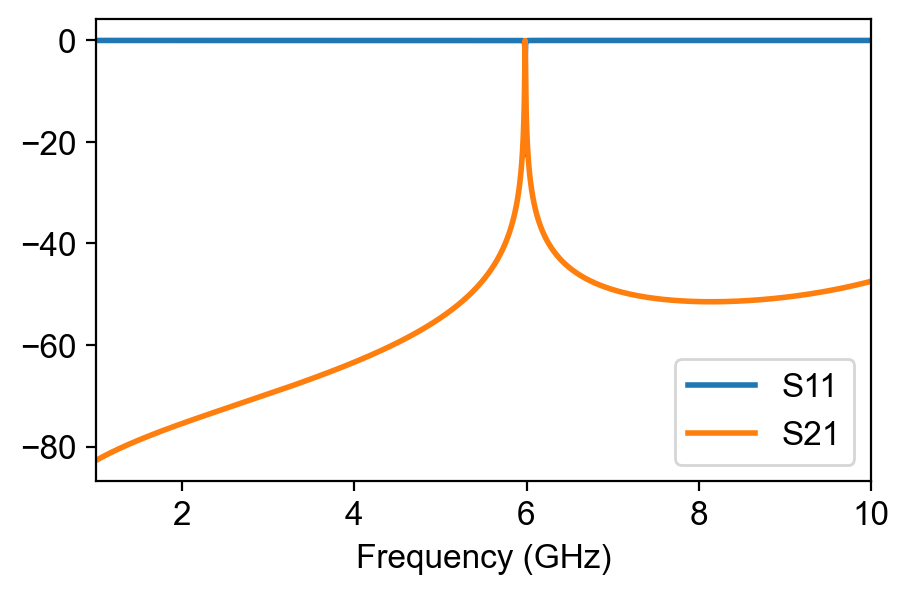

In [3]:
Z_0 = 50
l1 = 10e-3 # length of the transmission line resonator. 

# the necessary Frequency description
freq = rf.Frequency(start=1, stop=10, unit='GHz', npoints=10000)

port1 = rf.Circuit.Port(freq, 'port1', z0=Z_0)
port2 = rf.Circuit.Port(freq, 'port2', z0=Z_0)
gnd = rf.Circuit.Ground(frequency=freq, name='ground')

# Define a piece of transmission line
tline_media = cpw.CPW(freq, w=2e-6, s=10e-6, ep_r=11, rho=0)
trans_line_a = tline_media.line(l1, unit='m', name='trans_line_a')

# L and C are currently not used, but may be used for different circuits later.
C = tline_media.capacitor(1e-12, name='C')
L = tline_media.inductor(1e-9, name='L')
C_c1 = tline_media.capacitor(1e-14, name='C_in')
C_c2 = tline_media.capacitor(1e-14, name='C_out')

# Construct the network
cnx = [[(port1, 0), (C_c1, 0)],
       [(C_c1, 1), (trans_line_a, 0)],
       [(trans_line_a, 1), (C_c2, 0)],
       [(C_c2, 1), (port2, 0)]]

cir = rf.Circuit(cnx)
ntw = cir.network

# Plot the transmission
plt.figure(figsize=(5.,3.))
ntw.plot_s_db(m=0, n=0, lw=2, logx=False)
ntw.plot_s_db(m=1, n=0, lw=2, logx=False)

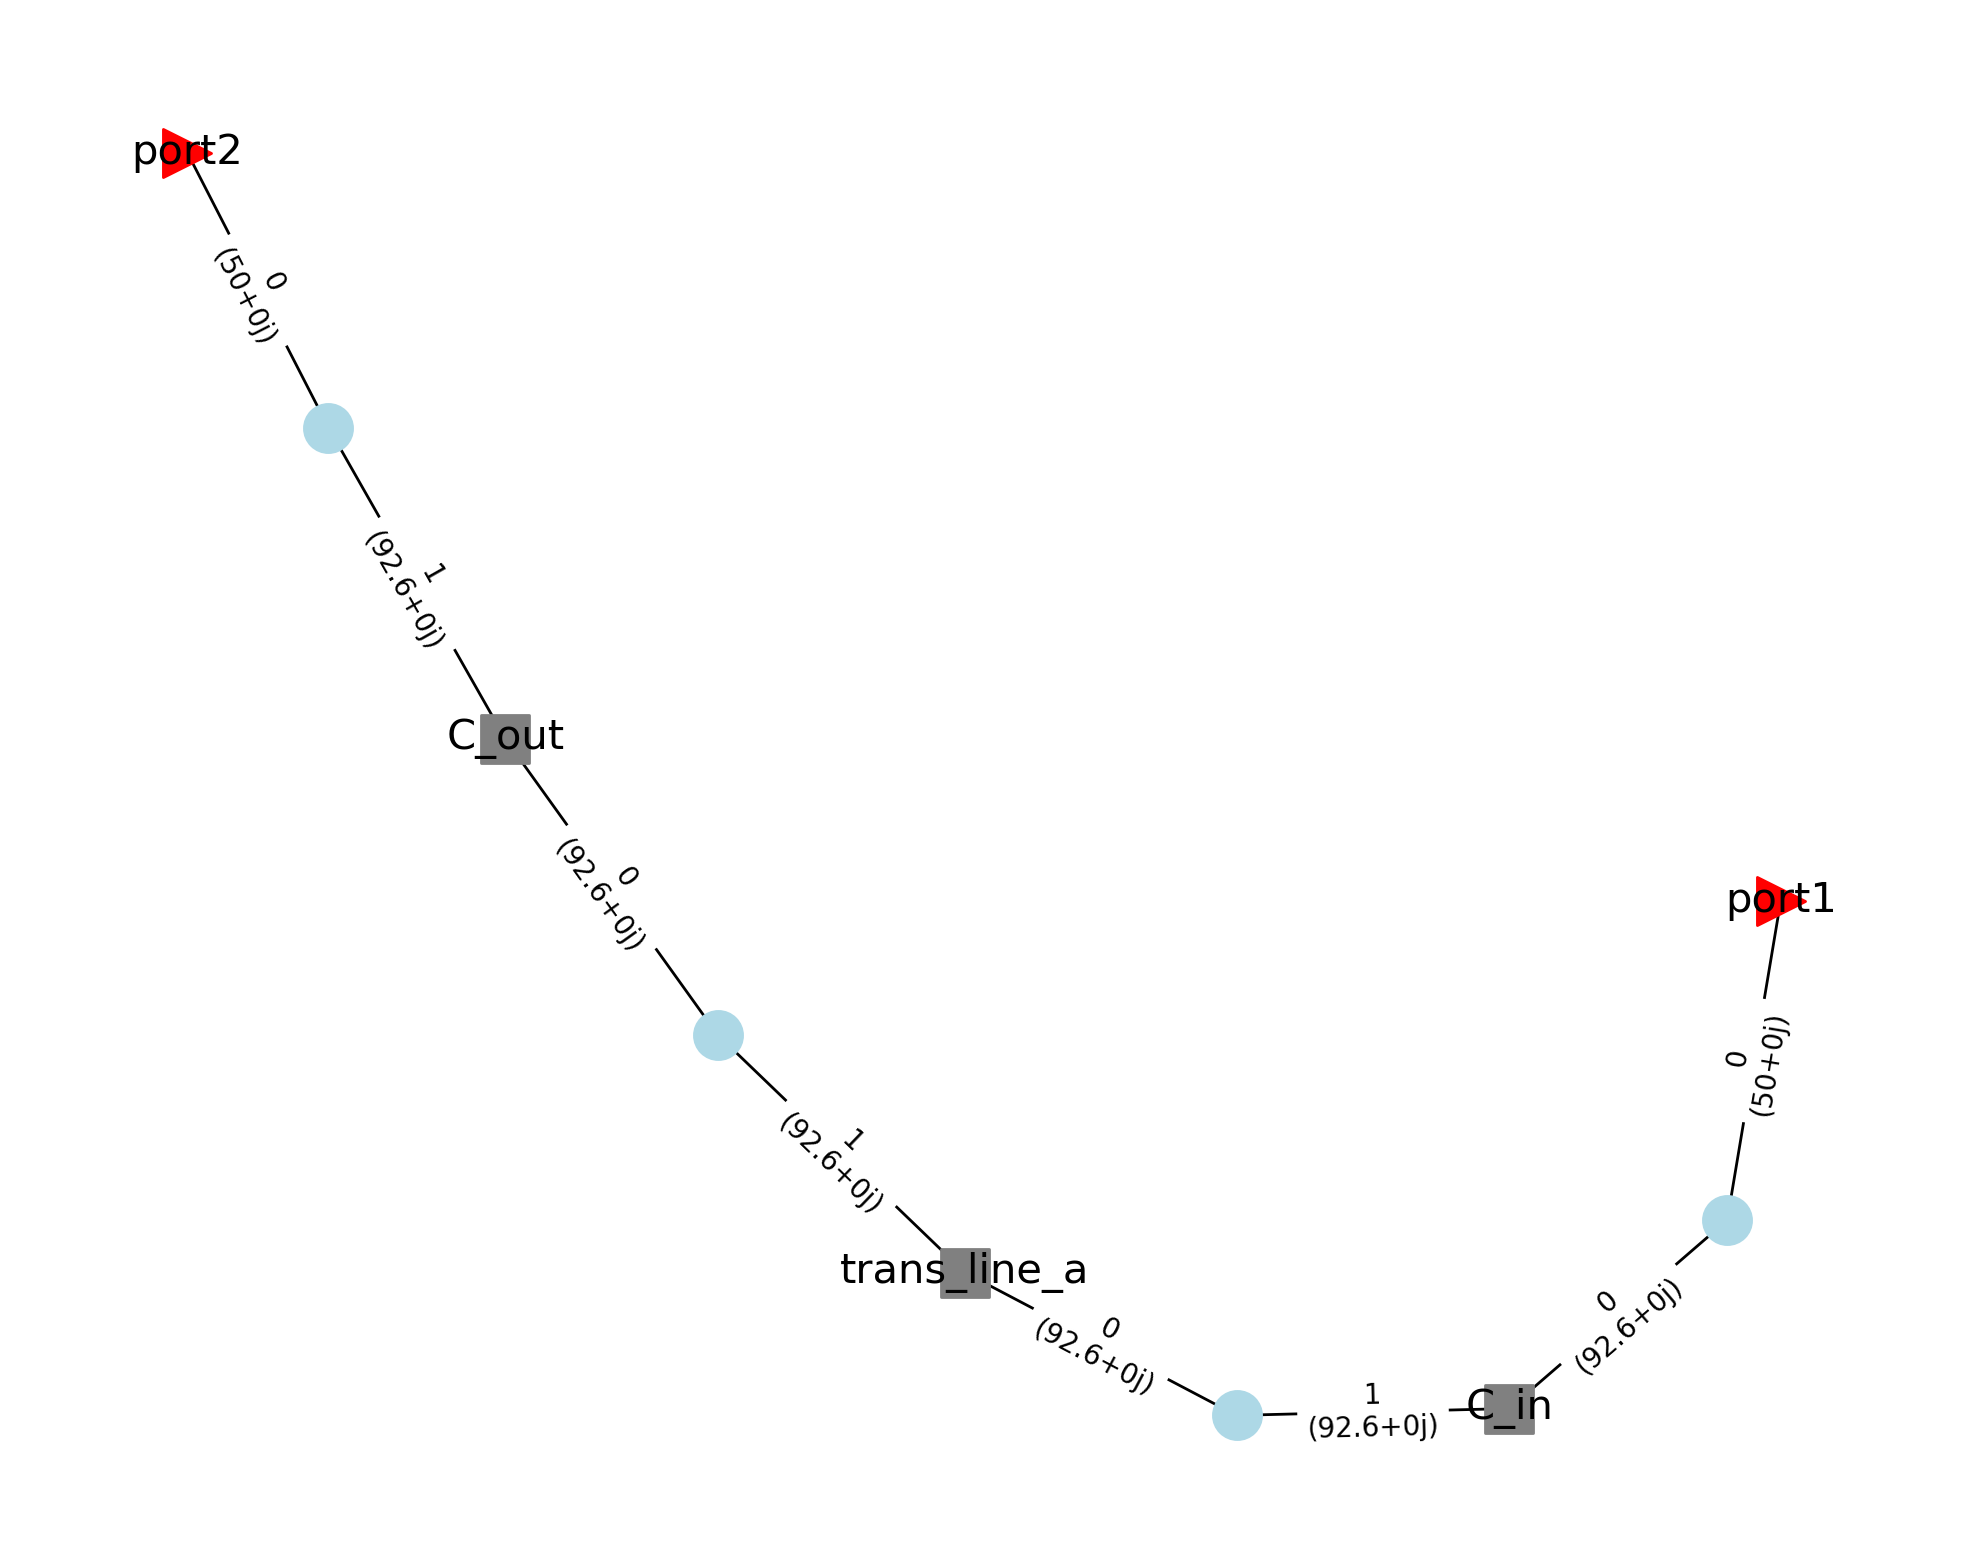

In [4]:
cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_labels=True, edge_fontsize=10)

# Transmission line with shunt capacitance <a class="anchor" id="section_1"></a>

We now study the effect of a shunt capacitor on the transmission line resonator properties. The shunt capacitance is in parallel with the inductor. The unit cell is still similar to the simple transmission line. However, including shunt capacitors adds extra terms involving $C_s$ to the Lagrangian:
$$
    \mathcal{L} = \frac{1}{2} C \dot{\phi}_n^2 + \frac{1}{2} C_s \left( \dot{\phi}_{n+1} - \dot{\phi}_{n}  \right)^2 
    + \frac{1}{2} C_s \left( \dot{\phi}_{n} - \dot{\phi}_{n-1}  \right)^2 - \frac{1}{2L} \left( \phi_{n+1} - \phi_{n} \right)^2  
    - \frac{1}{2L} \left( \phi_{n} - \phi_{n-1} \right)^2 + \ldots
$$

This results in the following equations of motion:
$$
    C \ddot{\phi}_n + C_s \left( 2 \ddot{\phi}_n  - \ddot{\phi}_{n+1} - \ddot{\phi}_{n-1} \right) 
    + \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right) = 0.
$$

To solve these equations numerically, we can write down the equivalent of Eq.~\eqref{eq:simple_tl_matrix_eq}:
$$ 
    \omega^2 \left [ (C + 2C_s) \phi_n - C_s \phi_{n+1} - C_s \phi_{n-1} \right] = 
    \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right), 
$$
Or written in matrix form:
$$
    [\mathbf{M}] = \begin{pmatrix}
        C + 2C_s & -C_s & 0 &\dots \\
        -C_s & C + 2C_s & -C_s & \dots \\
        0 & -C_s & C + 2C_s & \ddots \\
        \vdots & \vdots & \ddots & \ddots
    \end{pmatrix}
$$

$$
    [\mathbf{K}] = \frac{1}{L} \begin{pmatrix}
        2 & -1 & 0 &\dots \\
        -1 & 2 & -1 & \dots \\
        0 & -1 & 2 & \ddots \\
        \vdots & \vdots & \ddots & \ddots
    \end{pmatrix}
$$

In [5]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1), shunt_cap_fraction=(0, 4, 0.01), quarter_λ=False)
def update(dx_um=25, total_length_mm=2, L_total_nH=100, C_total_fF=33, shunt_cap_fraction=0.01, quarter_λ=False):
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    L_l = 1e-9 * L_total_nH / unit_cells
    C_l = 1e-15 * C_total_fF / unit_cells
    C_s = C_l * shunt_cap_fraction

    K = np.diag(-1/L_l * np.ones(unit_cells-1), k=-1) + np.diag(2/L_l * np.ones(unit_cells), k=0) + np.diag(-1/L_l * np.ones(unit_cells-1), k=1)
    M = np.diag(-C_s * np.ones(unit_cells-1), k=-1) + np.diag((C_l + 2 * C_s) * np.ones(unit_cells), k=0) + np.diag(-C_s * np.ones(unit_cells-1), k=1)

    if quarter_λ:
        # This shorts one end of the transmission line to ground.
        K[-1, -1] = 1 / L_l

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    print(1/(2 * unit_cells * dx * 1e9) * 1/ np.sqrt(L_l * C_l / dx / dx))

    fig, ax = plt.subplots(1, 2, figsize=(10.,3.))
    
    x = np.arange(unit_cells) * dx * 1e3
    for k in range(4):
        ax[0].plot(x, evecs_sorted[:, k])

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Phase eigenvector $\phi_n$ (a.u.)")

    for k in range(20):
        if k <= 4:
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')
        else:
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o', color='lightgray')

    # Dispersion with shunt capacitance:
    m = np.arange(7)
    if quarter_λ:
        f_with_shunt = (2 * m + 1) / (4 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15)) * np.sqrt(1 / (1 + (m * np.pi / unit_cells) ** 2 * C_s / C_l))
        f_wo_shunt = (2 * m + 1) / (4 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15))
    else:
        f_with_shunt = (m + 1) / (2 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15)) * np.sqrt(1 / (1 + (m * np.pi / unit_cells) ** 2 * C_s / C_l))
        f_wo_shunt = (m + 1) / (2 * 1e9) * np.sqrt(1 / (L_total_nH * 1e-9 * C_total_fF * 1e-15))

    ax[1].plot(m, f_wo_shunt, 's', mfc='none', mec='k', label="Theory without shunt")
    ax[1].plot(m, f_with_shunt, 'd', mfc='none', mec='k', label="Theory with shunt")

    ax[1].set_xlabel("Mode number")
    ax[1].set_ylabel("Mode frequency (GHz)")
    ax[1].set_ylim(0, 35)
    plt.legend(loc=4, frameon=False)



interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

In the toy model above, it's fun to try to increase the `shunt_capacitance_fF` to see that the higher frequency modes are starting to get affected. Higher frequency modes pass through the shunt capacitor more easily since the impedance scales as $1/\omega$

# Meandering resonator with shunt capacitances <a class="anchor" id="section_2"></a>

Having laid the basis with a simple transmission line and a shunted transmission line, we now move to the most accurate model of a meandering resonator. Using this model, we can study the effect of shunt capacitance between the meanders.

We start with the relevant terms in the Lagrangian of the unit cell, which involves nodes $n$ and $n+1$:
$$
    \mathcal{L} = \frac{1}{2} C \dot{\phi}_n^2
    + \frac{1}{2} C_s \left( \dot{\phi}_{n+1} - \dot{\phi}_{n-1}  \right)^2 + \frac{1}{2} C_s \left( \dot{\phi}_{n+3} - \dot{\phi}_{n+1}  \right)^2  
    - \frac{1}{2L} \left( \phi_{n+1} - \phi_{n} \right)^2 - \frac{1}{2L} \left( \phi_{n+2} - \phi_{n+1} \right)^2 + \ldots
$$
This yields two separate equations of motion for $\phi_n$ and $\phi_{n+1}$, because the structure is translationally invariant every two unit cells.
$$
    C \ddot{\phi}_n + \frac{1}{L} \left( 2\phi_n - \phi_{n+1} - \phi_{n+1} \right) = 0
$$ 
and 
$$
    C_s \left( 2 \ddot{\phi}_{n+1} - \ddot{\phi}_{n-1} - \ddot{\phi}_{n+3} \right) + \frac{1}{L} \left( 2 \phi_{n+1} - \phi_{n} - \phi_{n+2} \right) = 0
$$
The corresponding matrices are
\begin{align}
    [\mathbf{M}] = \begin{pmatrix}
        C & 0    & 0     & 0     & 0     & 0     & 0 & \dots \\
        0 & 2C_s  & 0     & -C_s  & 0 & 0 & 0 & \dots \\
        0 & 0    & C     & 0     & 0     & 0     & 0 & \ddots \\
        0 & -C_s    & 0     & 2C_s  & 0     & -C_s  & 0 & \ddots \\  
        \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & \ddots
    \end{pmatrix}
\end{align}

\begin{align}
    [\mathbf{K}] = \frac{1}{L} \begin{pmatrix}
        2 & -1 & 0 &\dots \\
        -1 & 2 & -1 & \dots \\
        0 & -1 & 2 & \ddots \\
        \vdots & \vdots & \ddots & \ddots
    \end{pmatrix}
\end{align}
Note that every meander has two separate equations, and therefore the dimensions of $[\mathbf{K}]$ and $[\mathbf{M}]$ are $2N \times 2N$ where each segment is $N$ are the number of segments in the transmission line. 


In [6]:
@widgets.interact(L_per_meander_nH=(1, 25, 0.1), Cg_per_meander_fF=(0.1, 10, 0.01), meanders=(10, 20, 1), shunt_cap_fraction=(0.01, 4, 0.01))
def update(L_per_meander_nH=12.4, Cg_per_meander_fF=1.4, meanders=16, shunt_cap_fraction=1.0):
    L_l = L_per_meander_nH * 1e-9
    C_g = Cg_per_meander_fF * 1e-15
    C_s = C_g * shunt_cap_fraction
    dx = 75e-6 

    K = np.diag(-1/L_l * np.ones(2 * meanders -1), k=-1) + np.diag(2/L_l * np.ones(2 * meanders), k=0) + np.diag(-1/L_l * np.ones(2 * meanders-1), k=1)

    diag_0 = np.zeros(2 * meanders)
    diag_0[::2] = C_g
    diag_0[1::2] = 2 * C_s

    diag_plus_2 = np.zeros(2 * meanders - 2)
    diag_plus_2[1::2] = -C_s
    diag_minus_2 = np.zeros(2 * meanders - 2)
    diag_minus_2[1::2] = -C_s

    M = np.diag(diag_0, k=0) + np.diag(diag_plus_2, k=2) + np.diag(diag_minus_2, k=-2)

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    print("Theory, without shunt: ", 1/(2 * meanders * dx * 1e9) * 1/ np.sqrt(2 * L_l * C_g / dx / dx))

    fig, ax = plt.subplots(1, 2, figsize=(10.,3.))
    
    x = np.arange(2 * meanders) * dx * 1e3
    for k in range(5):
        ax[0].plot(x, evecs_sorted[:, k])

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Phase eigenvector $\phi_n$ (a.u.)")

    for k in range(15):
        if k <= 4:
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')
        else:
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o', color='lightgray')

    print("Simulated, with shunt: ", np.sqrt(ev_sorted[0]) / (2 * np.pi * 1e9))

    # Dispersion with shunt capacitance:
    m = np.arange(1, 8)
    f_with_shunt = m / (2 * 1e9) * np.sqrt(1 / (meanders * 2 * L_l * meanders * C_g)) * np.sqrt(1 / (1 + (m * np.pi / meanders) ** 2 * C_s / C_g))
    f_wo_shunt = m / (2 * 1e9) * np.sqrt(1 / (meanders * 2 * L_l * meanders * C_g)) 

    ax[1].plot(np.arange(7), f_wo_shunt, 's', mfc='none', mec='k', label="Theory without shunt")
    ax[1].plot(np.arange(7), f_with_shunt, 'd', mfc='none', mec='k', label="Theory with shunt")

    ax[1].set_xlabel("Mode number")
    ax[1].set_ylabel("Mode frequency (GHz)")
    ax[1].set_ylim(0, 35)
    plt.legend(loc=4, frameon=False)

interactive(children=(FloatSlider(value=12.4, description='L_per_meander_nH', max=25.0, min=1.0), FloatSlider(…

Try varying the `shunt_capacitance_fF` slider and observe how the "theory without shunt" deviates more when the shunt capacitance is large. The "theory with shunt" remains in good agreement with the simulation. Note that this model is a good approximation for Josephson Junction Array Resonators. 

# Periodic transmission line with a break <a class="anchor" id="section_3"></a>

In this section we will change the boundary conditions such that the tips of a $\lambda/2$ resonator face eachoter at the location of the dot. We visualize the modes in a circle with a gap at the location of the dot. 

In [7]:
def plot_mode_profile(eigenvectors, eigenvalues, colorbar_label=r"Phase eigenvector $\phi$ (x)", clim=None, savepath=None):
    """Plots the eigenvectors of the folded transmission line circuit. 

    Args:
        eigenvectors (ArrayLike): 2D array such that eigenvectors[0] is the first eigenvector, etc.
        eigenvalues (ArrayLike): 1D array. The n-th eigenvalue should correspond to the n-th eigenvector.
        colorbar_label (regexp, optional): Defaults to r"Phase eigenvector $\phi$ (x)".
        savepath (_type_, optional): Save path for the figure. Defaults to None, in which case nothing is saved.
    """
    n = 6
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    ax = ax.flatten()
    for k in range(n):
        num_segments = len(eigenvectors[k])
        # eigenvector = eigenvector[num_segments//2 : -num_segments // 2]

        gap = 0.02
        theta_start = np.linspace((-1 + gap) * np.pi, (1 - gap) * np.pi, num_segments+1)[:-1]
        theta_end = np.linspace((-1 + gap) * np.pi, (1 - gap) * np.pi, num_segments+1)[1:]
        thetas = np.zeros(2*num_segments)
        thetas[::2] = theta_start
        thetas[1::2] = theta_end

        r = 1.00 

        arcs = [np.column_stack([r * np.cos(thetas[2*k:2*k+2]), r * np.sin(thetas[2*k:2*k+2])]) for k in range(len(thetas)//2)]

        # set axes limits manually because Collections do not take part in autoscaling
        ax[k].set_xlim(-1.1, 1.1)
        ax[k].set_ylim(-1.1, 1.1)
        ax[k].set_aspect("equal")  # to make the arcs look circular

        if clim is not None: 
            vmin, vmax = clim
        else:
            vmin = -np.abs(eigenvectors[k]).max()
            vmax = np.abs(eigenvectors[k]).max()

        # create a LineCollection with the half-circles and color mapping
        line_collection = LineCollection(arcs, array=np.roll(eigenvectors[k], num_segments // 2), cmap=plt.cm.RdBu_r, linewidth=6, 
                                         norm=plt.Normalize(vmin=vmin, vmax=vmax))
        ax[k].add_collection(line_collection)

        cbar = fig.colorbar(line_collection, ax=ax[k], label=colorbar_label, fraction=0.040, pad=0.03, format="%.0e")
        ax[k].set_title(f"f = {np.sqrt(eigenvalues[k]) / (2 * np.pi * 1e9):.2f} GHz")
        ax[k].axis('off')

    if savepath is not None: 
        fig.savefig(savepath, bbox_inches='tight', pad_inches=0.05)

## EOM solution in the $q$ basis

By starting in the charge basis, it is easier to add the electron-resonator coupling term to the Lagrangian.

\begin{align}
    \mathcal{L} &= \frac{L}{2} \sum_{n = 1}^N (\dot{q}_n^2 + \dot{q}_{-n}^2) \notag \\
    &- \frac{1}{2C} \sum_{n=1}^N \left[ \left( q_{n+1} - q_n \right)^2 + \left( q_{-n-1} -q_{-n} \right)^2 \right] \\
    &-\frac{q_0^2}{2C_\mathrm{dot}} - \frac{1}{2C} \left[ (q_1 - q_0)^2 + (q_{-1} - q_0)^2 \right].
    
\end{align}

Using shorthand notation for the dot capacitance $\alpha = C_\mathrm{dot}/ (C + 2C_\mathrm{dot})$, the matrices become
\begin{align}
    [\mathbf{M}] = L \mathbb{I}, 
\end{align}
where  $\mathbb{I}$ is the identity matrix, and 
\begin{align}
    [\mathbf{K}] = \frac{1}{C} \begin{pmatrix}
        2 & -1    & 0     & 0     & 0     & 0     & \dots & -1 \\
        -1 & 2  & -1     & 0  & 0 & 0 & \dots & 0 \\
         & \ddots & \ddots & \ddots &  &   &  \\
        0 &   0  & -1     & 2 - \alpha     & -\alpha     &  0  & 0& \ldots \\
        0 &   0  & 0 & -\alpha     & 2 - \alpha  & -1     & 0  & \ldots \\  
        \vdots & \vdots & \vdots & \ddots & \ddots & \ddots & \ddots & \ddots \\
        0 &   0  & 0     & 0     & 0     &  -1  & 2& -1 \\
        -1 &   0  & 0     & 0     & 0     &  0  & -1 & 2 \\
    \end{pmatrix}
\end{align}
Note that we have additionally implemented periodic boundary condition through the non-zero matrix elements for $[\mathbf{K}]_{-N, N}$ and $[\mathbf{K}]_{N, -N}$. The eigenvectors of $[\mathbf{M}]^{-1} [\mathbf{K}]$ are the charge distribution across the resonator.

In [8]:
def make_network(dx_um=25, total_length_mm=2, C_dot_fF=0.1, L_total_nH=100, C_total_fF=33, plot=True, return_all=False):
    """Calculates the eigenfrequencies of the folded transmission line resonator circuit in the charge basis.

    Args:
        dx_um (int, optional): Unit cell length in microns. Defaults to 25.
        total_length_mm (int, optional): Total length of the transmission line (This only determines the number of unit cells). Defaults to 2.
        C_dot_fF (float, optional): Dot capacitance in fF. Defaults to 0.1.
        L_total_nH (int, optional): Total inductance of the circuit in nH. Defaults to 100.
        C_total_fF (int, optional): Total capacitance of the transmission line in fF. Defaults to 33.
        plot (bool, optional): if true, it plots the eigenmodes and eigenfrequencies. Defaults to True.
        return_all (bool, optional): if true, it returns the eigenfrequencies, modes and voltage across the capacitor. Defaults to False.

    Returns:
        Tuple: Eigenvector (sorted by ascending eigenfrequency), Eigenfrequencies (sorted by ascending eigenfrequency), Voltage across the capacitor
    """
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    if unit_cells % 2:
        unit_cells += 1

    assert not(unit_cells % 2)
    L_l = L_total_nH * 1e-9 / unit_cells
    C_l = C_total_fF * 1e-15 / unit_cells
    C_dot = C_dot_fF * 1e-15

    K = np.diag(-1 * np.ones(unit_cells-1), k=-1) + np.diag(2 * np.ones(unit_cells), k=0) + np.diag(-1 * np.ones(unit_cells-1), k=1)
    M = L_l * C_l * np.diag(np.ones(unit_cells), k=0)

    alpha = C_dot / (C_l + 2 * C_dot)

    idx_minus1 = unit_cells // 2 - 1
    idx_plus1 = unit_cells // 2 + 1

    K[idx_minus1:idx_plus1, idx_minus1:idx_plus1] = np.array([[2 - alpha, -alpha], 
                                                              [-alpha, 2 - alpha]])

    # Periodic boundary conditions
    K[0, -1] = -1
    K[-1, 0] = -1

    ev, evecs = np.linalg.eig(np.linalg.inv(M) @ K)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(10.,3.))
    
    deltaVs = list()
    for k in range(6):
        # Shifted eigenvector
        evec_shifted = np.roll(evecs_sorted[:, k], unit_cells // 2)

        # Determine the voltage across the capacitor
        q0 = alpha * (evec_shifted[0] + evec_shifted[-1])
        deltaVs.append(q0 / C_dot)

        # Figure out what is the charge across the center capacitor
        evec_shifted = np.insert(evec_shifted, 0, q0)
        
        x = np.arange(unit_cells + 1) * dx * 1e3
        if plot:
            ax[0].plot(x, evec_shifted)

    if plot:
        ax[0].set_xlim(-0.05, np.max(x)+0.05)
        ax[0].set_xlabel("Position along the transmission line (mm)")
        ax[0].set_ylabel(r"Charge eigenvector $q_n$ (a.u.)")

        for k in range(20):
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')

        m = np.arange(7)
        f_no_dot = (m + 1)/(2*total_length_mm * 1e-3 * 1e9) * 1 / np.sqrt(L_l * (C_l + 0*C_dot/unit_cells) / dx / dx)
        ax[1].plot(m, f_no_dot, 'd', mfc='none', mec='k', label="Theory without dot")

        ax[1].set_xlabel("Mode number")
        ax[1].set_ylabel("Mode frequency (GHz)")
        ax[1].set_ylim(0, 30)
        ax[1].legend(loc=0, frameon=False)
        
        plot_mode_profile(evecs_sorted.T, ev_sorted, colorbar_label="Charge eigenvector $q$ (x)")

    if return_all:
        return evecs_sorted, ev_sorted, deltaVs

In [10]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), C_dot_fF=(0.01, 100, 0.1), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1))
def update(dx_um=25, total_length_mm=2, C_dot_fF=0.1, L_total_nH=200, C_total_fF=33):
    make_network(dx_um=dx_um, total_length_mm=total_length_mm, C_dot_fF=C_dot_fF, 
                 L_total_nH=L_total_nH, C_total_fF=C_total_fF, plot=True, return_all=False)

interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

In the widget above, try increasing `C_dot_fF` to be approximately `C_total_fF` and observe as the mode frequencies start to split into doublets. This is a sign of hybridization of mode frequencies into differential and common.

### Sweeping $C_\mathrm{dot}$

We're sweeping the dot capacitance to see _how much can we increase the dot capacitance before it starts to negatively affect the resonance?_

We're plotting this against the parameter $\alpha = C_\mathrm{dot} / (C + C_\mathrm{dot})$, because this parameter appears in the matrix equations and controls the transparency of the dot.

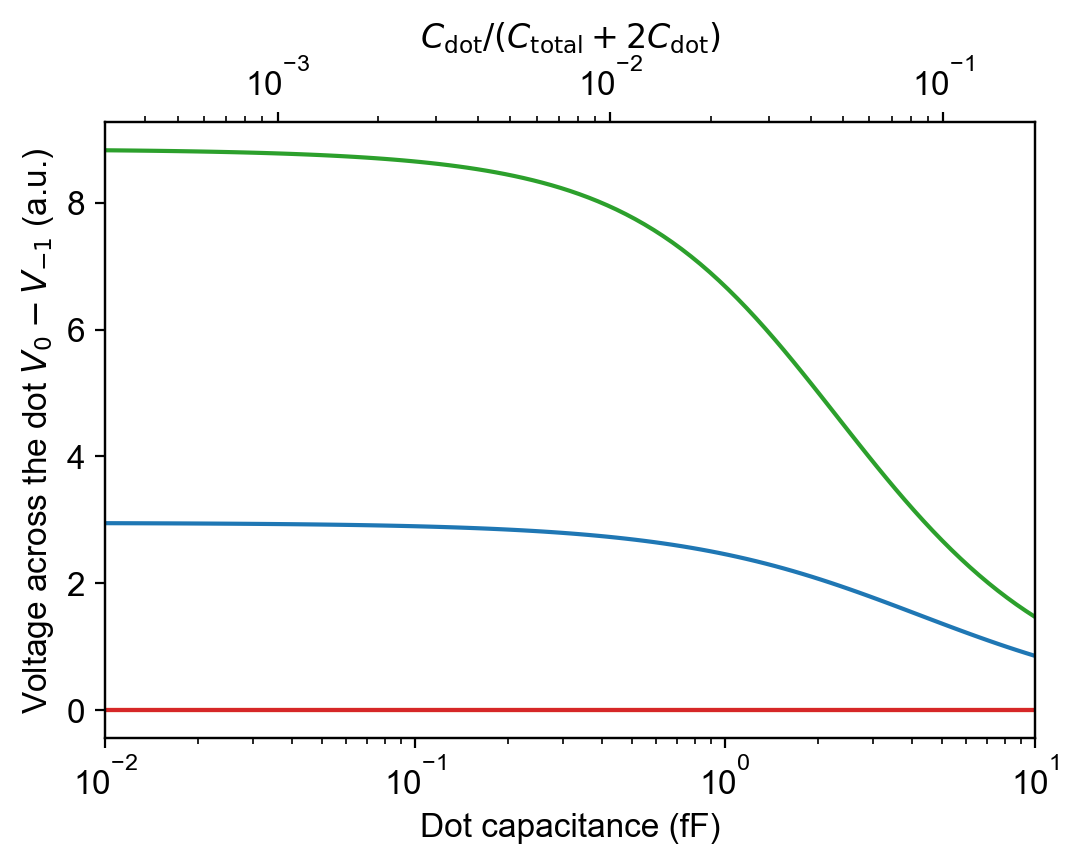

In [11]:
dx_um=25
total_length_mm=2
dot_capacitances_fF = np.logspace(-2, 1, 101)

do_plot = False
deltaV = np.zeros((len(dot_capacitances_fF), 6))
eigenfreqs = np.zeros((len(dot_capacitances_fF), 6))

fig = plt.figure(figsize=(6.,4.))

for L_total_nH, C_total_fF, linestyle in zip([200], [33], ['-']):
    for m, C_dot_fF in enumerate(dot_capacitances_fF):  
        evecs_sorted, ev_sorted, dV = make_network(dx_um=dx_um, total_length_mm=total_length_mm, C_dot_fF=C_dot_fF, 
                                                   L_total_nH=L_total_nH, C_total_fF=C_total_fF, plot=False, return_all=True)
        
        deltaV[m, :] = np.abs(np.array(dV))
        eigenfreqs[m, :] = np.sqrt(ev_sorted[:6]) / (2 * np.pi * 1e9)

    for k in range(4):
        plt.plot(dot_capacitances_fF, deltaV[:, k] / 1e13, linestyle)

    plt.xlabel("Dot capacitance (fF)")
    plt.ylabel("Voltage across the dot $V_0 - V_{-1}$ (a.u.)")
    plt.xlim(dot_capacitances_fF.min(), dot_capacitances_fF.max())
    plt.xscale('log')

    ax1 = plt.gca()
    ax2 = ax1.twiny()
    ax2.set_xscale('log')
    xmin, xmax = ax1.get_xlim()
    ax2.set_xlim(xmin / (C_total_fF + 2*xmin), xmax / (C_total_fF + 2*xmax))
    ax2.set_xlabel("$C_\mathrm{dot} / (C_\mathrm{total} + 2 C_\mathrm{dot})$")

Text(0.5, 0, '$C_\\mathrm{dot} / (C_\\mathrm{total} + 2 C_\\mathrm{dot})$')

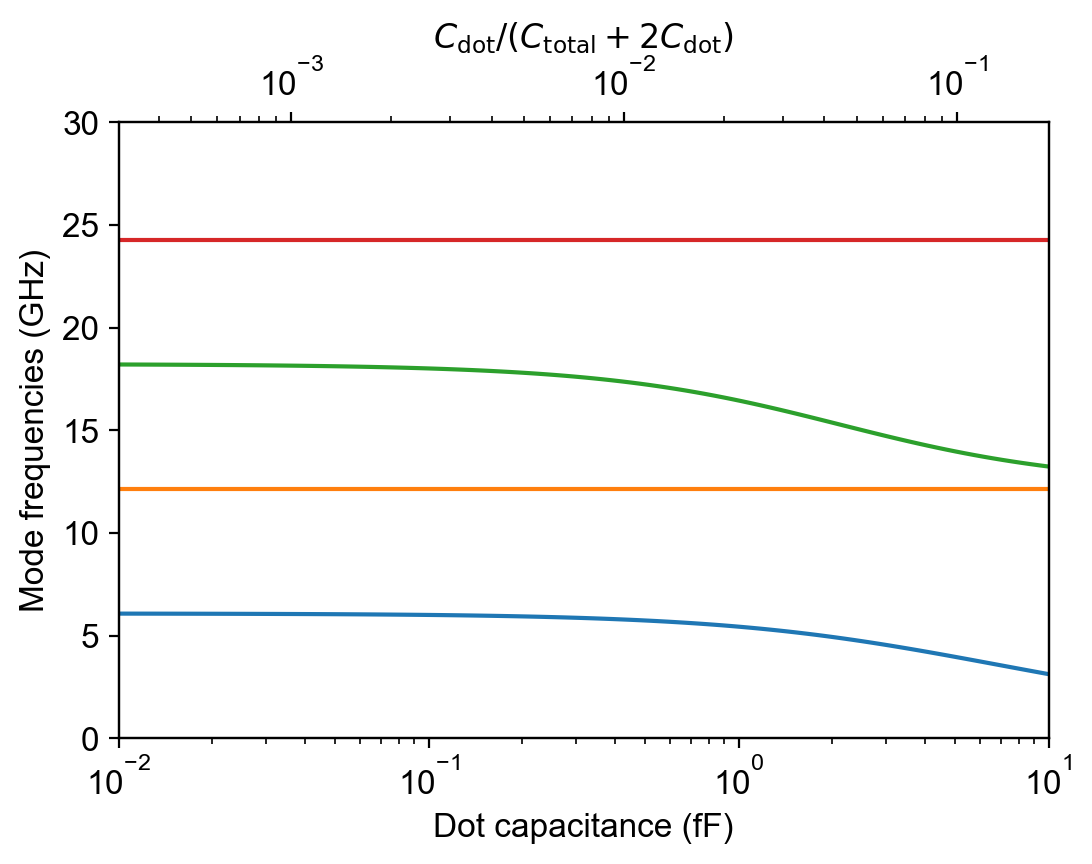

In [12]:
fig = plt.figure(figsize=(6., 4.))
for k in range(4):
    plt.plot(dot_capacitances_fF, eigenfreqs[:, k])
plt.xlabel("Dot capacitance (fF)")
plt.ylabel("Mode frequencies (GHz)")
plt.ylim(0, 30)
plt.xlim(dot_capacitances_fF.min(), dot_capacitances_fF.max())
plt.xscale('log')

ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xscale('log')
xmin, xmax = ax1.get_xlim()
ax2.set_xlim(xmin / (C_total_fF + 2*xmin), xmax / (C_total_fF + 2*xmax))
ax2.set_xlabel("$C_\mathrm{dot} / (C_\mathrm{total} + 2 C_\mathrm{dot})$")

### Sweeping $Z_\mathrm{res}$

Here we'll keep the resonance frequency fixed, and find the total inductance and capacitance such that we sweep the resonator impedance linearly.
We'll use the following relations:

$$
\omega_0 = \frac{1}{\sqrt{L(C + 2C_\mathrm{dot})}} \\
Z = \sqrt{\frac{L}{C + 2C_\mathrm{dot}}}
$$
such that $L = Z / \omega_0$ and $C = 1 / \omega_0 Z - 2C_\mathrm{dot}$

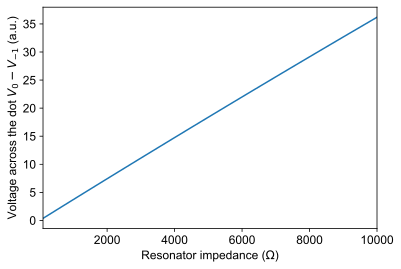

In [49]:
dx_um=25
total_length_mm=2
f0_diff = 6.1e9

C_dot_fF = 0.02
impedances = np.linspace(10 ** 2, 10 ** 4)
inductances = impedances / (2 * np.pi * f0_diff)
capacitances = 1 / (impedances * 2 * np.pi * f0_diff) - 2 * C_dot_fF * 1e-15

do_plot = False
deltaV = np.zeros((len(impedances), 6))
eigenfreqs = np.zeros((len(impedances), 6))

fig = plt.figure(figsize=(6.,4.))

m = 0
for L_total_nH, C_total_fF in zip(inductances * 1e9, capacitances * 1e15):
    evecs_sorted, ev_sorted, dV = make_network(dx_um=dx_um, total_length_mm=total_length_mm, C_dot_fF=C_dot_fF, 
                                                L_total_nH=L_total_nH, C_total_fF=C_total_fF, plot=False, return_all=True)
    
    deltaV[m, :] = np.abs(np.array(dV))
    eigenfreqs[m, :] = np.sqrt(ev_sorted[:6]) / (2 * np.pi * 1e9)

    m += 1

plt.plot(impedances, deltaV[:, 0] / 1e13)
plt.xlabel("Resonator impedance ($\Omega$)")
plt.ylabel("Voltage across the dot $V_0 - V_{-1}$ (a.u.)")
plt.xlim(impedances.min(), impedances.max())

The voltage across the dot scales linearly with the impedance because the total inductance $L \propto Z$ (when keeping $f_0$ constant) and $V_{n+1} - V_n = L \, dI_n / dt$. Note that this is not true for the zero-point fluctuations across the dot, which should scale with $\sqrt{Z}$ when the resonance frequency is kept fixed.

### Inspect mode profiles for a single parameter set

Use this cell below to inspect the mode profile for a specific parameter set.

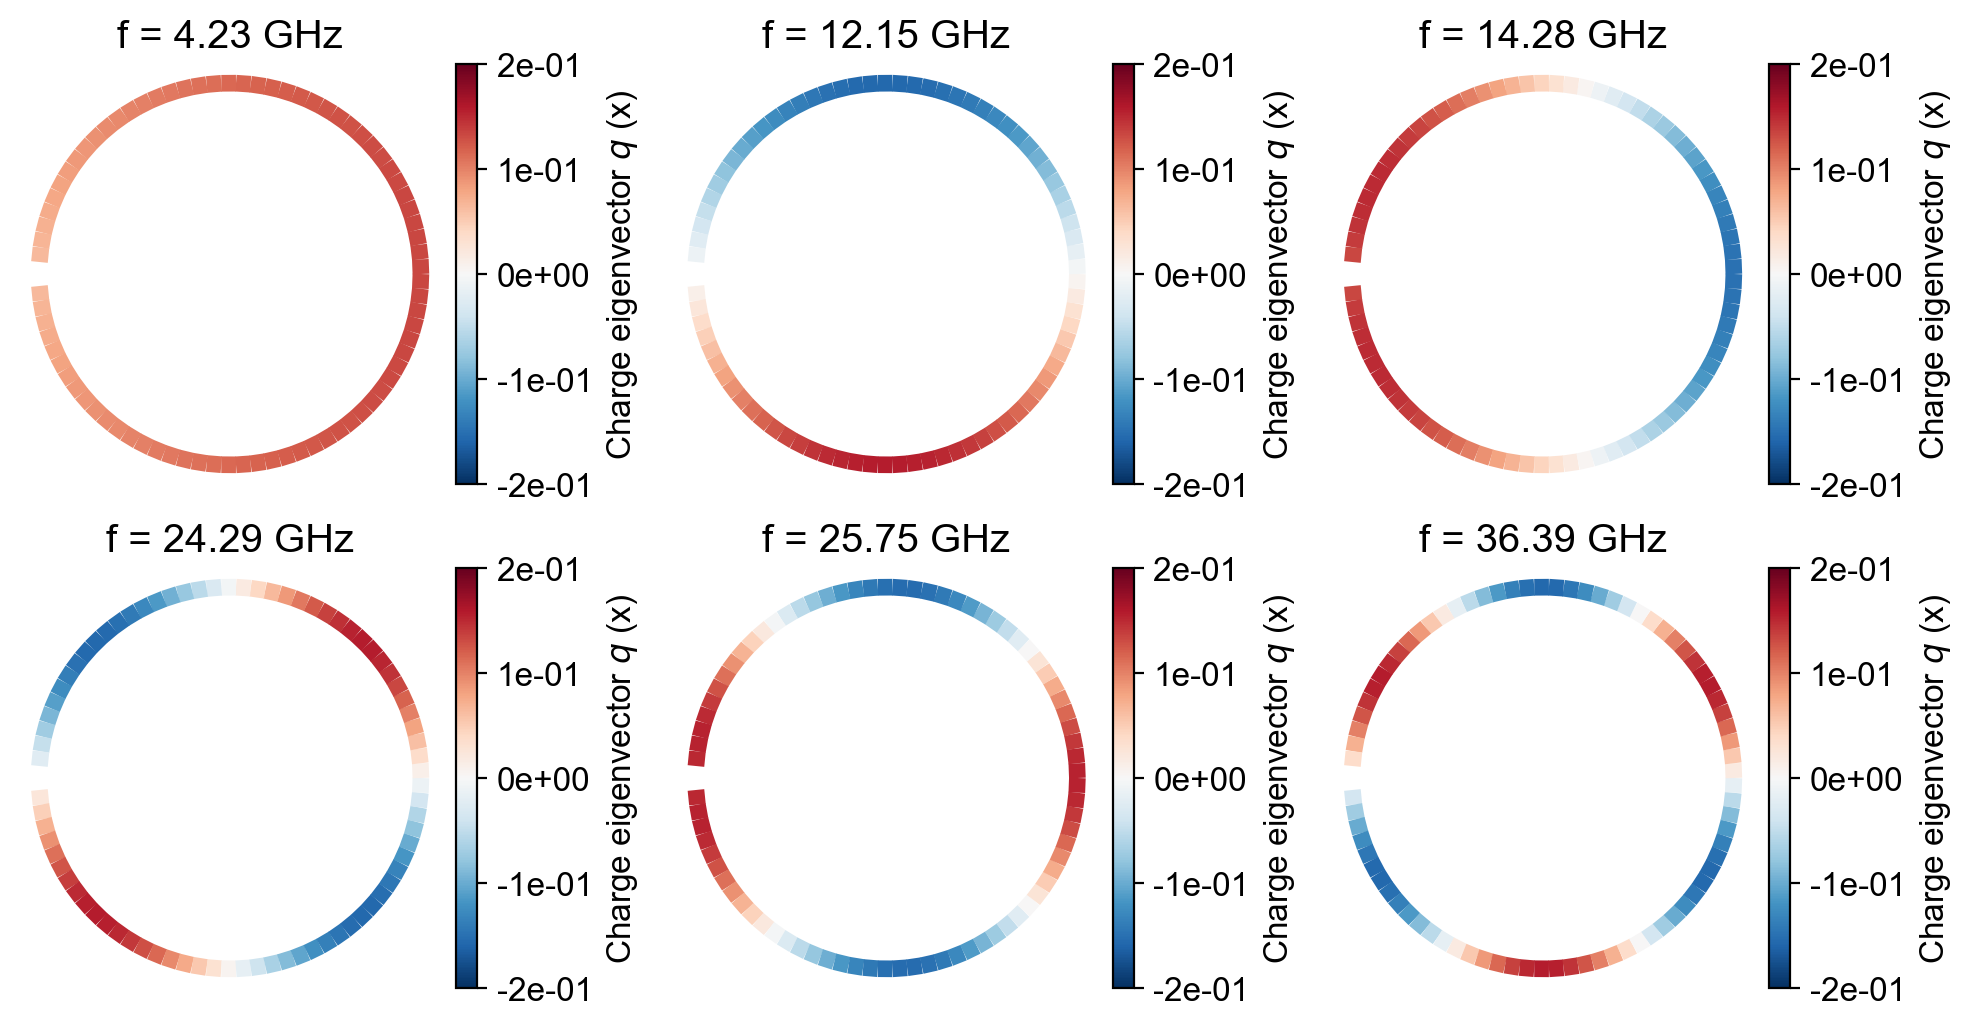

In [13]:
dx_um=25
total_length_mm=2
C_dot_fF = 4
L_total_nH= 200
C_total_fF= 33

evecs_sorted, ev_sorted, dV = make_network(dx_um=dx_um, total_length_mm=total_length_mm, C_dot_fF=C_dot_fF, 
                                            L_total_nH=L_total_nH, C_total_fF=C_total_fF, plot=False, return_all=True)

plot_mode_profile(evecs_sorted.T, ev_sorted, colorbar_label=r"Charge eigenvector $q$ (x)", clim=(-0.2, 0.2), savepath=None)

### Scikit RF model

Here we'll construct a sci-kit RF network to verify the behavior observed in the numerical EOM approach from the previous section. This network also contains input and output capacitors to probe the resonance.
We'll use `plot_s_db` to extract the transmission from port 1 to port 2. 

In [14]:
def make_scikit_network(L_total_nH, C_total_fF, C_dot_fF, fmin=1e9, fmax=15e9, plot=True, return_all=False):
    """Make the periodic transmission line resonator with a break in scikit-rf

    Args:
        L_total_nH (float): Total resonator inductance in nanohenries
        C_total_fF (float): Total resonator capacitance in femtofarads
        C_dot_fF (float): Dot capacitance in femtofarads
        fmin (float, optional): lower range of the frequency axis. Defaults to 1e9.
        fmax (float, optional): upper range of the frequency axis. Defaults to 15e9.
        plot (bool, optional): plot the results. Defaults to True.
        return_all (bool, optional): Defaults to False.

    Returns:
        ArrayLike: S21 scattering parameters (10,000 points)
    """
    Z_0 = 50
    Z_res = np.sqrt(L_total_nH*1e-9 / (C_total_fF * 1e-15))
    C_dot = C_dot_fF * 1e-15

    # The total length of the ring is 2 l1 + l2
    l1 = 2e-3
    l2 = 5e-3

    # The necessary frequency description
    freq = rf.Frequency(start=fmin, stop=fmax, unit='Hz', npoints=10000)

    port1 = rf.Circuit.Port(freq, 'port1', z0=Z_0)
    port2 = rf.Circuit.Port(freq, 'port2', z0=Z_0)
    gnd = rf.Circuit.Ground(frequency=freq, name='ground')

    # piece of transmission line and series impedance
    tline_media = cpw.CPW(freq, z0_override=Z_res, ep_r=11, rho=0)
    trans_line_a = tline_media.line(l1, unit='m', name='trans_line_a')
    trans_line_b1 = tline_media.line(l2, unit='m', name='trans_line_b1')
    trans_line_c = tline_media.line(l1, unit='m', name='trans_line_c')

    C_c1 = tline_media.capacitor(2e-15, name='C_in')
    C_c2 = tline_media.capacitor(2e-15, name='C_out')
    C_dot = tline_media.capacitor(C_dot, name='Cdot')

    cnx = [[(port1, 0), (C_c1, 0)],
        [(C_c1, 1), (trans_line_a, 0), (trans_line_b1, 0)],
        [(trans_line_a, 1), (C_dot, 0)],
        [(C_dot, 1), (trans_line_c, 1)], 
        [(trans_line_c, 0), (C_c2, 0), (trans_line_b1, 1)],
        [(port2, 0), (C_c2, 1)]]

    cir = rf.Circuit(cnx)
    ntw = cir.network

    if plot:
        plt.figure(figsize=(5.,3.))
        ntw.plot_s_db(m=0, n=0, lw=2, logx=False)
        ntw.plot_s_db(m=1, n=0, lw=2, logx=False)

    if return_all:
        # Return the element (0, 1) from the scattering matrix for the given frequencies
        return ntw.s[np.logical_and(ntw.f >= fmin, ntw.f <= fmax), 0, 1]

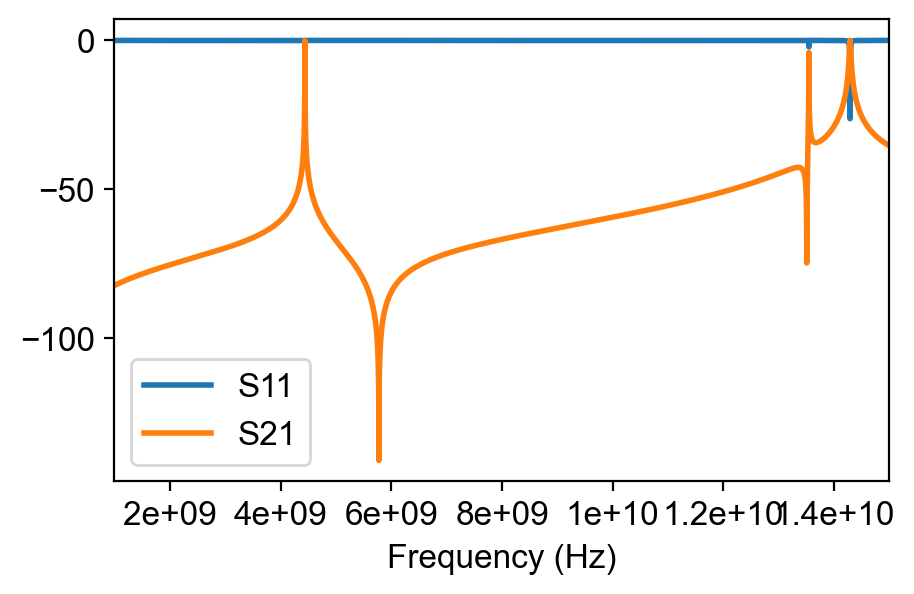

In [16]:
make_scikit_network(L_total_nH=200, C_total_fF=33, C_dot_fF=4, fmin=1e9, fmax=15e9, plot=True, return_all=False)

In the cell below, we'll sweep $C_\mathrm{dot}$ and show that the resulting behavior is similar to the EOM method. This sweep may take a few minutes, each time a new network has to be assembled.

In [17]:
dot_capacitances_fF = np.logspace(-2, 1, 101)
L_total_nH= 200
C_total_fF= 33

s21s = np.zeros((len(dot_capacitances_fF), 10000))

with alive_bar(len(dot_capacitances_fF), spinner='dots', force_tty=True) as bar:
    for m, C_dot_fF in enumerate(dot_capacitances_fF):  
        s21 = make_scikit_network(L_total_nH=L_total_nH, C_total_fF=C_total_fF, C_dot_fF=C_dot_fF, fmin=1e9, fmax=30e9, plot=False, return_all=True)
        s21s[m, :] = 20 * np.log10(np.abs(s21))
        bar()

|████████████████████████████████████████| 101/101 [100%] in 1:13.5 (1.37/s)                                            


Text(0, 0.5, 'Frequency (GHz)')

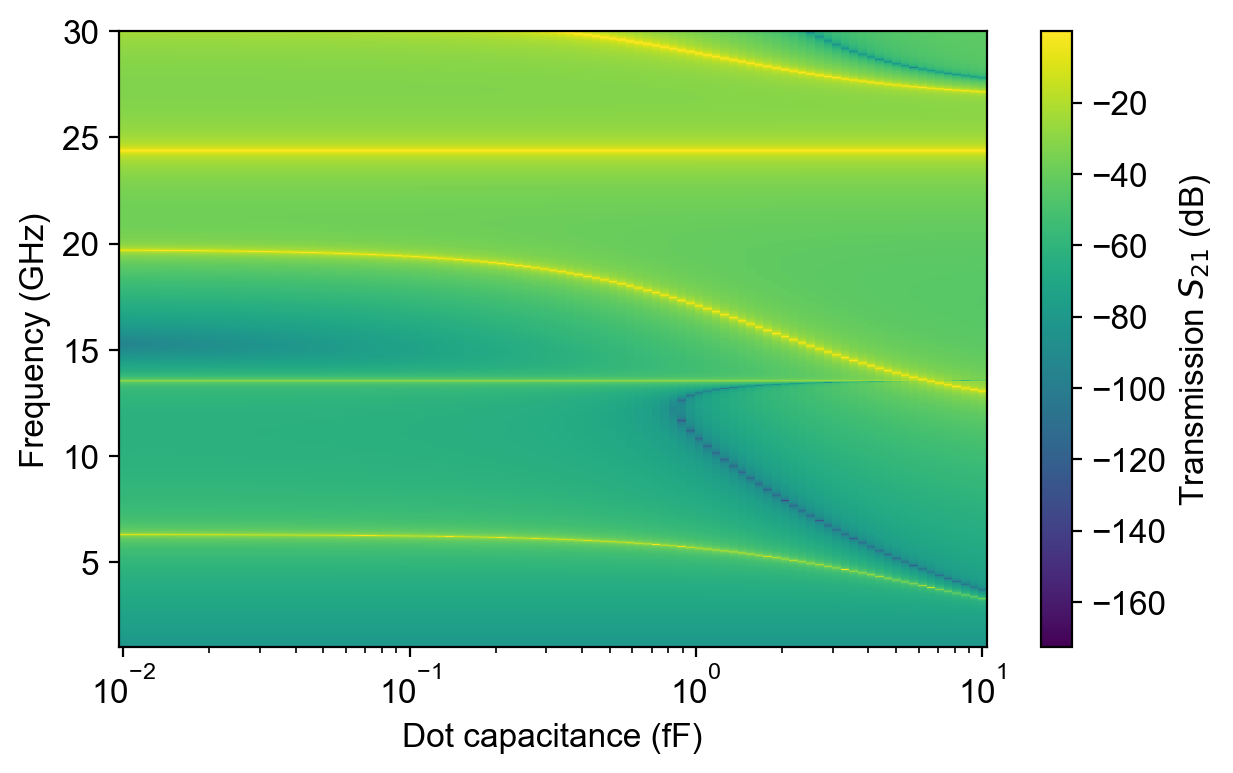

In [18]:
fig = plt.figure(figsize=(7.,4.))
plt.pcolormesh(dot_capacitances_fF, np.linspace(1, 30, 10000), s21s.T)
plt.colorbar(label=r"Transmission $S_{21}$ (dB)")
plt.xscale('log')
plt.xlabel("Dot capacitance (fF)")
plt.ylabel("Frequency (GHz)")

Compare this plot with the plot "Mode frequencies" vs. "Dot capacitance". In both cases there are modes that are independent of the Dot capacitance, as well as mode frequencies that decrease with dot capacitance. Overall the agreement is quite good. 

## EOM solution in the $\phi$ basis

Instead of solving the equations of motion in the charge basis, we may also set up the equations in the flux basis. We get the following Hamiltonian:

\begin{align}
    \mathcal{H} = &\frac{1}{D} \left[ \frac{1}{2}(C + C_\mathrm{dot}) q_0^2 + \frac{1}{2}(C + C_\mathrm{dot})q_{-1}^2  + C_\mathrm{dot} q_0 q_{-1} \right] \notag \\ 
    & + \frac{1}{2C} \sum_{n=1}^N q_n^2 + \frac{1}{2C} \sum_{n=2}^N q_{-n}^2 \\
    & + \frac{1}{2L} \sum_{n=1}^N \left[ \left( \phi_n - \phi_{n-1} \right)^2 + \left( \phi_{-n} - \phi_{-n-1} \right)^2 \right],
\end{align}
where $D = C^2 + 2C C_\mathrm{dot} = C (C + 2 C_\mathrm{dot})$, and the charges $q_n$ are now defined on the nodes (in contrast to the previous Lagrangian derived from the loop method). 

We find: 
$\vec{\dot{\phi}} = [\mathbf{C}^{-1}] \vec{q}$, where
\begin{align}
    [\mathbf{C}^{-1}] = \frac{1}{C} \begin{pmatrix}
        1 & 0    & 0      & 0        & \dots & 0  & 0   & 0   \\
        0 & 1  & 0     & 0  & \dots & 0  & 0  & 0   \\
        \vdots &  & \ddots & &  &   &  & \\
        0 &   0 & 0 &  1-\alpha     & \alpha      & 0 & \ldots  & 0  \\
        0 &   0 & 0 &  \alpha  & 1-\alpha & 0     & \ldots  & 0  \\  
        \vdots & \vdots & \vdots &  &  &  \ddots & & \\
        0 &   0     & 0     & \dots   & 0   & 0    & 1& 0 \\
        0 &   0     & 0     & \dots    & 0  & 0    & 0 & 1 \\
    \end{pmatrix}
\end{align}

and $\vec{\dot{q}} = [\mathbf{L}^{-1}] \vec{\phi}$, where
\begin{align}
    [\mathbf{L}^{-1}] = \frac{1}{L} \begin{pmatrix}
        -2 & 1    & 0      & 0        & \dots & 0  & 0   & 1   \\
        1 & -2  & 1     & 0  & \dots & 0  & 0  & 0   \\
        \vdots & \ddots & \ddots & \ddots &  &   &  & \\
        0 &   0 & 1 &  -1     & 0      & 0 & \ldots  & 0  \\
        0 &   0 & 0 &  0  & -1 & 1     & \ldots  & 0  \\  
        \vdots & \vdots & \vdots &  &  \ddots &  \ddots & \ddots & \\
        0 &   0     & 0     & \dots   & 0   & 1    & -2& 1 \\
        1 &   0     & 0     & \dots    & 0  & 0    & 1 & -2 \\
    \end{pmatrix}
\end{align}

Combining  $\vec{\dot{\phi}} = [\mathbf{C}^{-1}] \vec{q}$ and $\vec{\dot{q}} = [\mathbf{L}^{-1}] \vec{\phi}$, we have $\vec{\ddot{q}} = [\mathbf{L}^{-1}][\mathbf{C}^{-1}] \vec{q}$. Therefore, we seek the eigenvalues and eigenvectors of the matrix $ [\mathbf{L}^{-1}][\mathbf{C}^{-1}]$. In particular, the eigenvalues are given by
\begin{equation}
    \omega^2 = \mathrm{eig} \left( - [\mathbf{L}^{-1}][\mathbf{C}^{-1}] \right).
\end{equation}
The eigenvectors obtained this way are charge amplitudes $q_n$ defined on the nodes. Since this quantity has little physical meaning, we instead study the eigenvectors in the voltage basis from $\vec{\dot{\phi}} = [\mathbf{C}^{-1}] \vec{q}$.

In [20]:
@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), C_dot_fF=(0.01, 100, 0.1), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1))
def update(dx_um=25, total_length_mm=2, C_dot_fF=4, L_total_nH=200, C_total_fF=33, save=False):
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    L_l = 1e-9 * L_total_nH / unit_cells
    C_l = 1e-15 * C_total_fF / unit_cells
    C_dot = C_dot_fF * 1e-15

    Linv = np.diag(1/L_l * np.ones(unit_cells-1), k=-1) + np.diag(-2/L_l * np.ones(unit_cells), k=0) + np.diag(1/L_l * np.ones(unit_cells-1), k=1)
    Cinv = np.diag(1/C_l * np.ones(unit_cells), k=0)

    idx_minus1 = unit_cells // 2 - 1
    idx_plus1 = unit_cells // 2 + 1

    α = C_dot / (C_l + 2 * C_dot)

    Cinv[idx_minus1:idx_plus1, idx_minus1:idx_plus1] = np.array([[(1 - α) / C_l, α / C_l], 
                                                                 [α / C_l, (1 - α) / C_l]])

    Linv[idx_minus1:idx_plus1, idx_minus1-1:idx_plus1+1] = np.array([[1 / L_l, -1 / L_l, 0, 0], 
                                                                     [0, 0, -1 / L_l, 1 / L_l]])

    # Periodic boundary conditions
    Linv[0, -1] = 1 / L_l
    Linv[-1, 0] = 1 / L_l

    ev, evecs = np.linalg.eig(-Linv @ Cinv)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    fig, ax = plt.subplots(1, 2, figsize=(8.,3.))

    x = np.arange(unit_cells) * dx * 1e3
    for k in range(4):
        voltage_vec = Cinv @ evecs_sorted[:, k]
        ax[0].plot(x, np.roll(voltage_vec, unit_cells // 2))

    ax[0].set_xlim(-0.05, np.max(x)+0.05)
    ax[0].set_xlabel("Position along the transmission line (mm)")
    ax[0].set_ylabel(r"Voltage eigenvector $\dot{\phi}_n$ (a.u.)")
    
    # Convert the charge eigenvectors to voltage using the capacitance matrix
    evecs_voltage = [Cinv @ evec_charge for evec_charge in evecs_sorted.T]

    for k in range(20):
        ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')

    ax[1].set_xlabel("Mode number")
    ax[1].set_ylabel("Mode frequency (GHz)")
    ax[1].set_ylim(0, 40)
    
    fig.tight_layout()

    savepath = None #if save is None else "put your savepath here"

    plot_mode_profile(evecs_voltage, ev_sorted, colorbar_label=r"Voltage mode profile $V (x)$", 
                      savepath=savepath)

interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

We see that the eigenmodes predicted by this method are similar.

## Coupling electrons to the resonator <a class="anchor" id="section_6"></a>

To further understand the new generalized versions of $[\mathbf{C}^{-1}]$ and $[\mathbf{L}^{-1}]$, we first study the system where only a single electron couples to the dot. In addition, we assume the motion of this electron is constrained along the $x$-direction, which is still experimentally relevant. In this case the equations of motion simplify substantially, and because there is only one electron term, we may drop the subscript $i$ for the electron coordinate: $\delta x_i = \delta x$. We work in the basis where $\vec{q} = (q_{-N}, \ldots, q_{-1}, q_0, \ldots, q_N, \delta x)^T$ and $\vec{\phi} = (\phi_{-N}, \ldots, \phi_{-1}, \phi_0, \ldots, \phi_N, p_x)^T$, such that $[\mathbf{C}^{-1}]$ and $[\mathbf{L}^{-1}]$ become

\begin{align}
    [\mathbf{\tilde{C}}^{-1}] = \frac{1}{C} \begin{pmatrix}
        1 & 0    & 0      & 0        & \dots & 0  & 0   & 0 & 0  \\
        0 & 1  & 0     & 0  & \dots & 0  & 0  & 0 & 0  \\
        \vdots &  & \ddots & &  &   &  & & \\
        0 &   0 & 0 &  1-\alpha     & \alpha      & 0 & \ldots  & 0 & e \beta_x^{(-1)} \\
        0 &   0 & 0 &  \alpha  & 1-\alpha & 0     & \ldots  & 0 & e \beta_x^{(0)}\\  
        \vdots & \vdots & \vdots &  &  &  \ddots & & &\\
        0 &   0     & 0     & \dots   & 0   & 0    & 1& 0  & 0\\
        0 &   0     & 0     & \dots    & 0  & 0    & 0 & 1 & 0 \\
        0 &   0     & 0     & e \beta_x^{(-1)} & e \beta_x^{(0)} & 0 & 0 & 0 & e C \frac{\partial^2 V_\mathrm{DC}}{\partial x^2}
    \end{pmatrix}
\end{align}
and 
\begin{align}
    [\mathbf{\tilde{L}}^{-1}] = \frac{1}{L} \begin{pmatrix}
        -2 & 1    & 0      & 0        & \dots & 0  & 0   & 1 & 0  \\
        1 & -2  & 1     & 0  & \dots & 0  & 0  & 0  & 0  \\
        \vdots & \ddots & \ddots & \ddots &  &   &  &  &\\
        0 &   0 & 1 &  -1     & 0      & 0 & \ldots  & 0 & 0  \\
        0 &   0 & 0 &  0  & -1 & 1     & \ldots  & 0 & 0  \\  
        \vdots & \vdots & \vdots &  &  \ddots &  \ddots & \ddots & &\\
        0 &   0     & 0     & \dots   & 0   & 1    & -2& 1 & 0 \\
        1 &   0     & 0     & \dots   & 0   & 0    & 1 & -2 & 0 \\
        0 &   0     & 0     & \dots   & 0   & 0    & 0 & 0  & -L/m_e
    \end{pmatrix}
\end{align}
Note that the tilde signals the generalized nature of the inverse capacitance and inductance matrices. To study the effect of the coupled electron we diagonalize the system and compute
\begin{equation}
    \omega^2 = \mathrm{eig} \left( - [\mathbf{\tilde{L}}^{-1}][\mathbf{\tilde{C}}^{-1}] \right).
\end{equation}

In [21]:
def diagonalize_this(dx_um=25, total_length_mm=2, C_dot_fF=0.1, L_total_nH=100, C_total_fF=33, 
                     omega_e=2*np.pi*10e9, alpha_a_prime=0.2e6, alpha_b_prime=-0.2e6, plot=False):
    """Diagonalize the coupled system of split ring resonator and electron. There is only one electron. 
    alpha_a_prime and alpha_b_prime are the E-fields per 1V applied to each capacitor plate.
    For more information see the note on overleaf.

    Args:
        dx_um (int, optional): Discretization of the transmission line in microns. Defaults to 25.
        total_length_mm (int, optional): Total lengthin mm, does not determine resonance frequency. Defaults to 2.
        C_dot_fF (float, optional): Dot capacitance in fF. Defaults to 0.1.
        L_total_nH (int, optional): Total inductance in nH. Defaults to 100.
        C_total_fF (int, optional): Total capacitance in fF. Defaults to 33.
        omega_e (_type_, optional): Electron frequency (in units rad/s). Defaults to 2*np.pi*10e9.
        alpha_a_prime (_type_, optional): E-field of capacitor plate 'a'. Defaults to 0.2e6.
        alpha_b_prime (_type_, optional): E-field of capacitor plate 'b'. Defaults to -0.2e6.
        plot (bool, optional): Plots the diagonalization result. Defaults to False.

    Returns:
        tuple: eigenvectors, eigenfrequencies
    """
    
    dx = dx_um * 1e-6
    unit_cells = int(total_length_mm / (dx_um / 1e3))

    L_l = 1e-9 * L_total_nH / unit_cells
    C_l = 1e-15 * C_total_fF / unit_cells
    C_dot = C_dot_fF * 1e-15

    Linv = np.diag(1/L_l * np.ones(unit_cells-1), k=-1) + np.diag(-2/L_l * np.ones(unit_cells), k=0) + np.diag(1/L_l * np.ones(unit_cells-1), k=1)
    Cinv = np.diag(1/C_l * np.ones(unit_cells), k=0)

    idx_minus1 = unit_cells // 2 - 1
    idx_plus1 = unit_cells // 2 + 1

    α = C_dot / (C_l + 2 * C_dot)

    β_x_a = (1 - α) * alpha_a_prime + α * alpha_b_prime
    β_x_b = (1 - α) * alpha_b_prime + α * alpha_a_prime

    Cinv[idx_minus1:idx_plus1, idx_minus1:idx_plus1] = np.array([[(1 - α) / C_l, α / C_l], 
                                                                 [α / C_l, (1 - α) / C_l]])

    Linv[idx_minus1:idx_plus1, idx_minus1-1:idx_plus1+1] = np.array([[1 / L_l, -1 / L_l, 0, 0], 
                                                                     [0, 0, -1 / L_l, 1 / L_l]])

    # Periodic boundary conditions
    Linv[0, -1] = 1 / L_l
    Linv[-1, 0] = 1 / L_l

    # Add electron to the generalized Linv matrix
    Linv_tilde = np.zeros((unit_cells + 1, unit_cells + 1))
    Linv_tilde[:-1, :-1] = Linv
    Linv_tilde[-1, -1] = - 1 / m_e

    # Add electron to the generalized Cinv matrix
    Cinv_tilde = np.zeros((unit_cells + 1, unit_cells + 1))
    Cinv_tilde[:-1, :-1] = Cinv
    Cinv_tilde[-1, -1] = m_e * omega_e ** 2
    Cinv_tilde[-1, idx_minus1:idx_plus1] = Cinv_tilde[idx_minus1:idx_plus1, -1] = q_e / C_l * np.array([β_x_a, β_x_b])

    ev, evecs = np.linalg.eig(-Linv_tilde @ Cinv_tilde)
    order = np.argsort(ev)

    ev_sorted = ev[order]
    evecs_sorted = evecs[:, order]

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(8.,3.))

        x = np.arange(unit_cells) * dx * 1e3
        for k in range(4):
            voltage_vec = Cinv @ evecs_sorted[:-1, k]
            voltage_vec /= np.max(np.abs(voltage_vec))
            ax[0].plot(x, np.roll(voltage_vec, unit_cells // 2))

        ax[0].set_xlim(-0.05, np.max(x)+0.05)
        ax[0].set_xlabel("Position along the transmission line (mm)")
        ax[0].set_ylabel(r"Voltage eigenvector $\dot{\phi}_n$ (a.u.)")
    
        # Convert the charge eigenvectors to voltage using the capacitance matrix
        evecs_voltage = [Cinv @ evec_charge[:-1] for evec_charge in evecs_sorted.T]

        for k in range(20):
            ax[1].plot(k, np.sqrt(ev_sorted[k]) / (2 * np.pi * 1e9), 'o')

        m = np.arange(7)
        f_no_dot = (m + 1)/(2*total_length_mm * 1e-3 * 1e9) * 1 / np.sqrt(L_l * (C_l + 0*C_dot/unit_cells) / dx / dx)
        ax[1].plot(m+1, f_no_dot, 'd', mfc='none', mec='k', label="Theory without dot")

        ax[1].set_xlabel("Mode number")
        ax[1].set_ylabel("Mode frequency (GHz)")
        ax[1].set_ylim(0, 40)
        
        fig.tight_layout()

    # plot_mode_profile(evecs_voltage, ev_sorted, colorbar_label=r"Voltage mode profile $V (x)$")

    return evecs_sorted, np.sqrt(ev_sorted) / (2 * np.pi)

In [ ]:
warnings.filterwarnings("ignore")

@widgets.interact(dx_um=(1, 100, 1), total_length_mm=(0.5, 10, 0.05), C_dot_fF=(0.0, 100, 0.1), L_total_nH=(1, 500, 1), C_total_fF=(1, 200, 1), f_e=(0, 40, 0.01))
def update(dx_um=25, total_length_mm=2, C_dot_fF=0.1, L_total_nH=100, C_total_fF=33, f_e=10.0, Ex=0.2e6):
    params = {"dx_um" : dx_um, 
              "total_length_mm" : total_length_mm, 
              "C_dot_fF" : C_dot_fF, 
              "L_total_nH" : L_total_nH, 
              "C_total_fF" : C_total_fF, 
              "omega_e" : 2*np.pi*f_e * 1e9, 
              "alpha_a_prime" : Ex, 
              "alpha_b_prime" : -Ex}
    
    _ = diagonalize_this(**params, plot=True)

interactive(children=(IntSlider(value=25, description='dx_um', min=1), FloatSlider(value=2.0, description='tot…

Hint: 
- Try sweeping `f_e` up and down while observing the mode frequencies, can you see which mode frequency is the electron mode?
- Try turning off and on the coupling with the value `Ex`. `Ex` is the electric field at the location of the electron.
- Does the value of `C_dot_fF` affect the electron mode? 

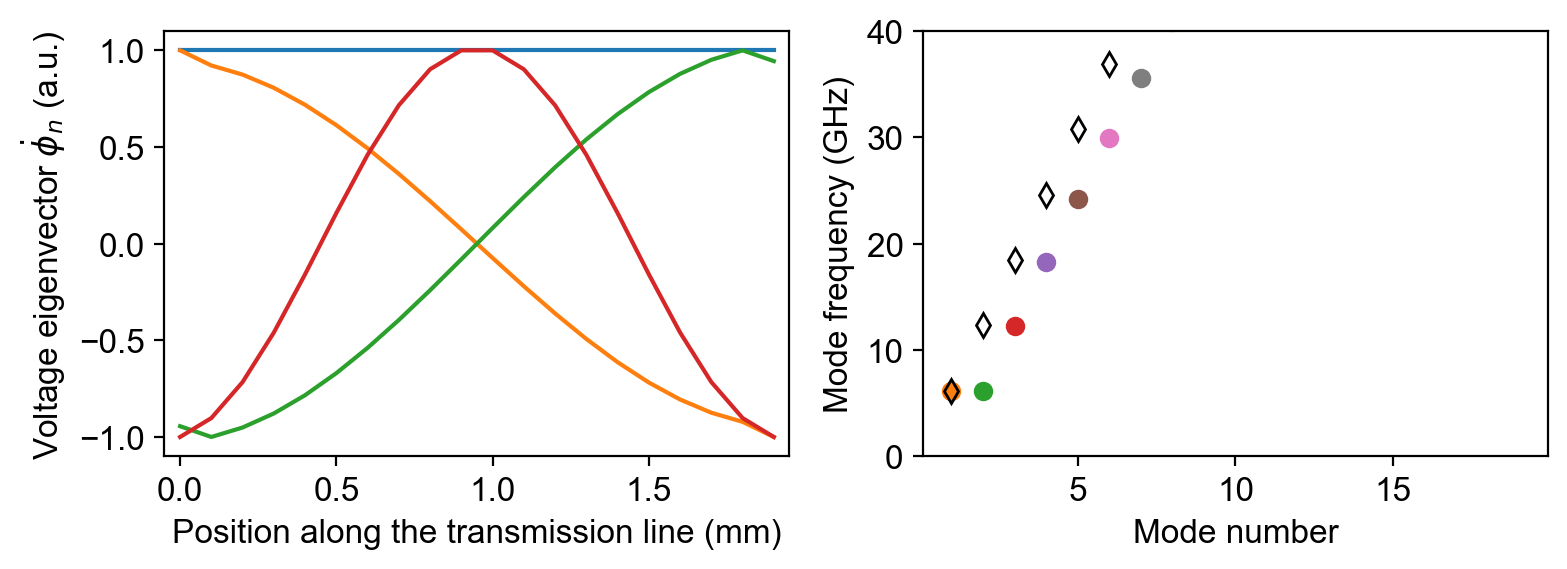

In [4]:
params = {"dx_um" : 100, 
          "total_length_mm" : 2, 
          "C_dot_fF" : 0.02, 
          "L_total_nH" : 200, 
          "C_total_fF" : 33, 
          "omega_e" : 2*np.pi*6.15e9, 
          "alpha_a_prime" : 0.2e6, 
          "alpha_b_prime" : -0.2e6}

evecs, evals = diagonalize_this(**params, plot=True)

### Sweep the electron frequency through the resonator

To study which resonator modes couple to the electron we sweep the electron frequency through each resonance. If the electron couples to a mode, there will be an avoided crossing. The size of the avoided crossing is $2g$.
The plots produced here can be compared with Fig. 2 of https://arxiv.org/pdf/2410.19592 

|████████████████████████████████████████| 2001/2001 [100%] in 52.7s (37.98/s)                                          
For Ex = 0.20 V/µm, we simulate g = 8.8 MHz
|████████████████████████████████████████| 2001/2001 [100%] in 49.1s (40.77/s)                                          
For Ex = 0.50 V/µm, we simulate g = 21.3 MHz


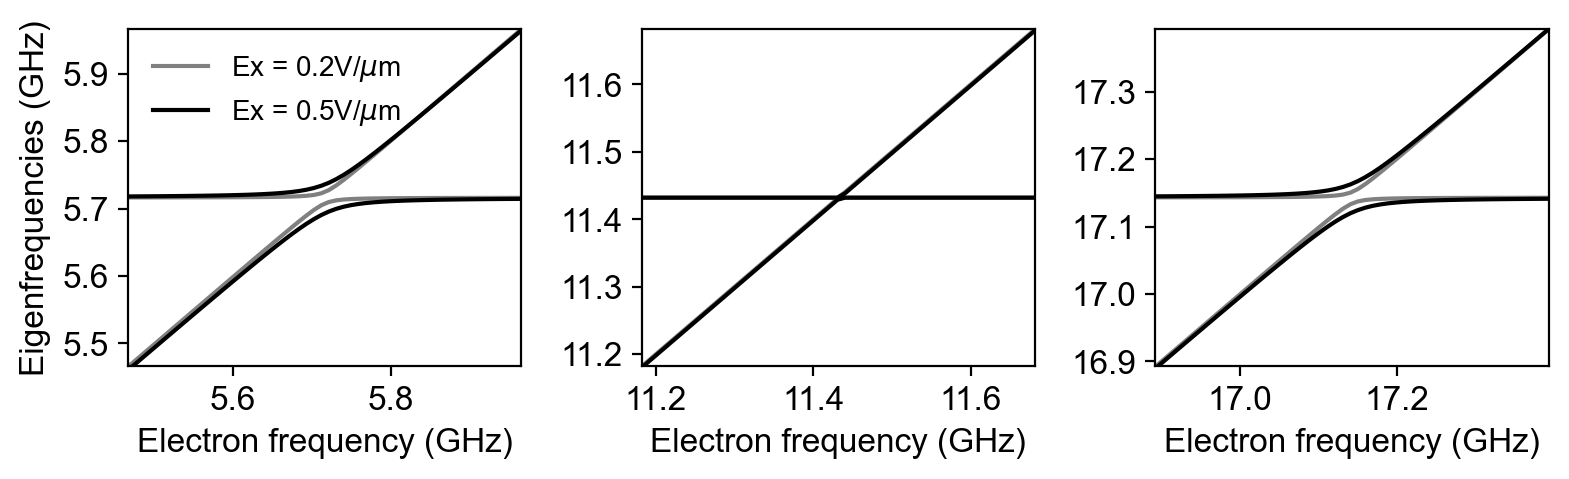

In [25]:
electron_freqs = np.linspace(1e9, 20e9, 2001)

max_modes = 6
eigenfrequencies = np.zeros((len(electron_freqs), max_modes))
fig, ax = plt.subplots(1, 3, figsize=(8., 2.5))

# This loops over two values of the electric field at the location of the electron. Larger Ex results in stronger coupling.
for Ex, color in zip([0.2e6, 0.50e6], ['gray', 'black']):
    
    params = {"dx_um" : 20, 
              "total_length_mm" : 2, 
              "C_dot_fF" : 0.02, 
              "L_total_nH" : np.pi*3.1, 
              "C_total_fF" : np.pi*250, 
              "omega_e" : np.nan, 
              "alpha_a_prime" : Ex, 
              "alpha_b_prime" : -Ex}

    with alive_bar(len(electron_freqs), spinner='dots', force_tty=True) as bar:
        for k, f_e in enumerate(electron_freqs):
            params["omega_e"] = 2 * np.pi * f_e
            evecs, efreqs = diagonalize_this(**params)

            eigenfrequencies[k] = np.sort(efreqs[1:max_modes+1])
            bar()

    for k in range(0,2):
        label = "" if k == 0 else f"Ex = {Ex/1e6}V/$\mu$m"
        ax[0].plot(electron_freqs/1e9, eigenfrequencies[:, k]/1e9, color=color, label=label)
        ax[0].set_ylim(electron_freqs.min()/1e9, electron_freqs.max()/1e9)

    ax[0].legend(loc=0, frameon=False, prop={"size" : 10})

    # Estimate g from the minimum distance.
    print(f"For Ex = {Ex/1e6:0.2f} V/µm, we simulate g = {0.5 * np.min(eigenfrequencies[:, 1] - eigenfrequencies[:, 0]) / 1e6 :.1f} MHz")

    for k in range(6):
        label = "" if k == 0 else f"Ex = {Ex/1e6}V/$\mu$m"
        ax[1].plot(electron_freqs/1e9, eigenfrequencies[:, k]/1e9, color=color, label=label)

    for k in range(6):
        label = "" if k == 0 else f"Ex = {Ex/1e6}V/$\mu$m"
        ax[2].plot(electron_freqs/1e9, eigenfrequencies[:, k]/1e9, color=color, label=label)

    bare_freqs = eigenfrequencies[-1, :3]
    for k in range(3):
        ax[k].set_xlabel("Electron frequency (GHz)")
        
        zoom = 0.5e9
        ax[k].set_xlim((bare_freqs[k] - zoom/2)/1e9, (bare_freqs[k] + zoom/2)/1e9)
        ax[k].set_ylim((bare_freqs[k] - zoom/2)/1e9, (bare_freqs[k] + zoom/2)/1e9)
    
    ax[0].set_ylabel("Eigenfrequencies (GHz)")

    fig.tight_layout()

Note that the second mode does not show an avoided crossing. This is because the voltage oscillates in tandem, i.e. it is a common mode that should indeed not couple to electrons in the dot.
Let us now calculate what we would expect for the coupling to the differential mode. 

In [26]:
unit_cells = params['total_length_mm'] / (params['dx_um'] * 1e-3)
dx = params['dx_um'] * 1e-6
L_l = params['L_total_nH'] * 1e-9 / unit_cells
C_l = params['C_total_fF'] * 1e-15 / unit_cells

Z0_diff = np.sqrt(params['L_total_nH'] * 1e-9 / (1e-15 * params['C_total_fF']))
f0_diff = 1/(2*params['total_length_mm'] * 1e-3) * 1 / np.sqrt(L_l * C_l / dx / dx)

for Ex in [0.212e6, 0.50e6]:
    Ex_tilde = np.sqrt(2) * (0.5 * Ex -- 0.5 * Ex)
    print(f"The impedance is {Z0_diff:.0f} Ω and fundamental frequency is {f0_diff/1e9:.3f} GHz.")
    print(f"For Ex = {Ex/1e6:0.2f} V/µm, we expect g/2π = {1e-6 * 0.5 * q_e * Ex_tilde * np.sqrt(Z0_diff * 2 * np.pi * f0_diff / m_e) / (2 * np.pi) : .1f} MHz")

The impedance is 111 Ω and fundamental frequency is 5.717 GHz.
For Ex = 0.21 V/µm, we expect g/2π =  8.0 MHz
The impedance is 111 Ω and fundamental frequency is 5.717 GHz.
For Ex = 0.50 V/µm, we expect g/2π =  18.9 MHz


These values for the coupling are in reasonable agreement with the extracted values from the avoided crossing above.

### Study the dispersive shift of the fundamental mode

When the trap curvature remains far detuned from the resonator, the resonator experiences a dispersive shift. For a single electron this shift is given by $g^2 / \omega_e - \omega_0$. We'll show below that this dispersive shift has the same magnitude as obtained from a simple $LC$ circuit as long as the capacitance is chosen carefully. Reasonable values for a high kinetic inductance resonator are `L_total_nH = np.pi*35` and `C_total_fF = np.pi*20`. For a regular Nb resonator we can expect values such as `L_total_nH = np.pi*5.52` and `C_total_fF = np.pi*138`. 

|████████████████████████████████████████| 21/21 [100%] in 2.4s (8.64/s)                                                


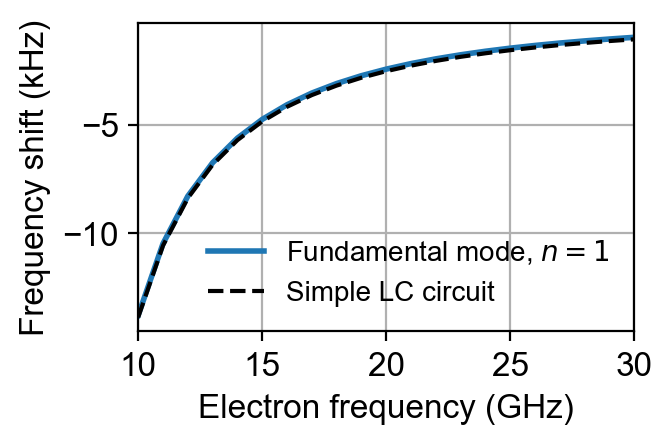

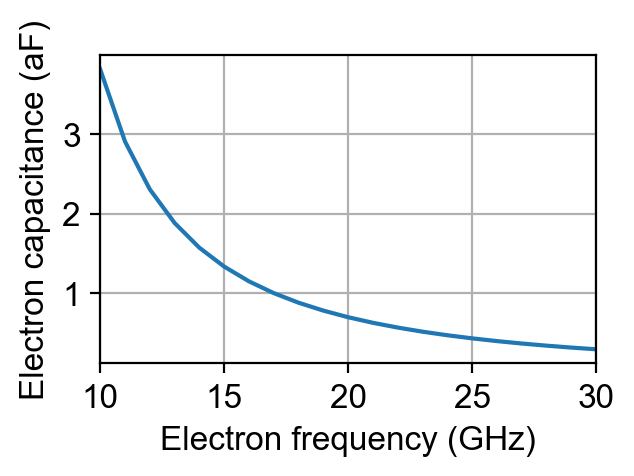

In [ ]:
from scipy.constants import elementary_charge, electron_mass

electron_freqs = np.linspace(10e9, 30e9, 21)
eigenfrequencies = np.zeros((len(electron_freqs), 6))

fig = plt.figure(figsize=(3.2, 2))

Ex = 0.212e6
# The factor of pi comes from setting the following two equal: f0 = 1 / 2 pi sqrt(Ltotal Ctotal) = 1 / 2l sqrt(L_l C_l) 
params = {"dx_um" : 10, 
          "total_length_mm" : 2, 
          "C_dot_fF" : 0.018, 
          "L_total_nH" : np.pi*3.1,#5.52, 
          "C_total_fF" : np.pi*250,#138, 
          "omega_e" : np.nan, 
          "alpha_a_prime" : Ex, 
          "alpha_b_prime" : -Ex}

# First find the bare resonator frequencies by detuning the electron really far.
params["omega_e"] = 2 * np.pi * 100e9
evecs, efreqs = diagonalize_this(**params)
f_no_electrons = np.sort(efreqs[1:max_modes+1])
f0_diff = f_no_electrons[0]

# Sweep the trap curvature (electron frequency) to observe the dispersive shift
with alive_bar(len(electron_freqs), spinner='dots', force_tty=True) as bar:
    for k, f_e in enumerate(electron_freqs):
        params["omega_e"] = 2 * np.pi * f_e
        evecs, efreqs = diagonalize_this(**params)
        eigenfrequencies[k] = np.sort(efreqs[1:max_modes+1])
        bar()

# And from here we calculate the frequency shifts (measured from the bare values)
plt.plot(electron_freqs/1e9, (eigenfrequencies[:, 0] - f0_diff) / 1e3, color='tab:blue', label=r'Fundamental mode, $n=1$', lw=2)

# Calculation of the capacitance change from the dispersive shift of the differential mode.
# The expression comes from a simple LC model, but if the resonance frequency shifts agree then this expression should be valid.
total_capacitance = params['C_total_fF'] * 1e-15
delta_c = (elementary_charge) ** 2 / (electron_mass * (2 * np.pi) ** 2 * (electron_freqs ** 2 - f0_diff ** 2)) * (np.sqrt(2) * (params['alpha_a_prime'] - params['alpha_b_prime'])) ** 2
simple_lc_shift = -f0_diff * 0.5 * delta_c / total_capacitance

plt.plot(electron_freqs/1e9, 1e-3 * simple_lc_shift, '--', color='black', label="Simple LC circuit")
plt.xlabel("Electron frequency (GHz)")
plt.ylabel("Frequency shift (kHz)")
# plt.ylim(-200, 1)
plt.grid()
plt.xlim(electron_freqs.min()/1e9, electron_freqs.max()/1e9)
plt.legend(loc=0, frameon=False, prop={"size" : 10})

plt.figure(figsize=(3.2, 2))
plt.plot(electron_freqs/1e9, delta_c * 1e18)
plt.xlabel("Electron frequency (GHz)")
plt.ylabel("Electron capacitance (aF)")
plt.xlim(electron_freqs.min()/1e9, electron_freqs.max()/1e9)
plt.grid()

In [28]:
unit_cells = params['total_length_mm'] / (params['dx_um'] * 1e-3)
dx = params['dx_um'] * 1e-6
L_l = params['L_total_nH'] * 1e-9 / unit_cells
C_l = params['C_total_fF'] * 1e-15 / unit_cells

Z0_diff = np.sqrt(params['L_total_nH'] * 1e-9 / (1e-15 * params['C_total_fF']))
f0_diff = 1/(2*params['total_length_mm'] * 1e-3) * 1 / np.sqrt(L_l * C_l / dx / dx)

print(f"The impedance is {Z0_diff:.0f} Ω and fundamental frequency is {f0_diff/1e9:.3f} GHz.")
print(f"For Ex = {Ex/1e6:0.2f} V/µm, we expect g/2π = {1e-6 * np.sqrt(2) * 0.5 * q_e * Ex * np.sqrt(Z0_diff * 2 * np.pi * f0_diff / m_e) / (2 * np.pi) : .1f} MHz")

The impedance is 111 Ω and fundamental frequency is 5.717 GHz.
For Ex = 0.21 V/µm, we expect g/2π =  8.0 MHz


## Verify the Lagrangian with `scqubits` 

With `scqubits` we can construct an arbitrary circuit composed of inductors and capacitors, and then write down the Lagrangian. This Lagrangian should equal
\begin{align}
    \mathcal{L} &= \frac{C}{2} \sum_{n=1}^N (\dot{\phi}_n^2 + \dot{\phi}_{-n}^2) + \frac{C \dot{\phi}_0 ^2}{2} + \frac{C_\mathrm{dot} (\dot{\phi}_0 - \dot{\phi}_{-1}) ^2}{2} \notag \\
    &- \frac{1}{2L} \sum_{n = 1}^{N} \left[ \left( \phi_n - \phi_{n-1} \right)^2 + \left( \phi_{-n} - \phi_{-n-1} \right)^2 \right].
\end{align}

In [31]:
# Make sure you install scqubits first.
import scqubits as scq

circuit = """# dot
branches:\n"""

# Increase to add more transmission line unit cells to the left and right of the dot
num_unit_cells = 1

# These are some arbitrary pre-factors that work out to unity in the lagrangian
# It'll make it easier to interpret the structure of the lagrangian.
L = 2
C = 0.0625

# Left unit cells
for n in range(1, num_unit_cells+1):
    unit_cell = f"""- [L, {n}, {n+1}, EL{n} = {L}]
- [C, {n+1}, 0, EC{n} = {C}]\n"""
    circuit += unit_cell

# The dot:
circuit += f"""- [C, {num_unit_cells+1}, {num_unit_cells+2}, ECdot = 0.125]
- [C, {num_unit_cells+2}, 0, EC2 = 0.0625]"""

# Right unit cells
for n in range(num_unit_cells+2, 2*num_unit_cells+2):
    if n == 2*num_unit_cells+1:
        unit_cell = f"\n- [L, {n}, {1}, EL{n} = {L}]\n"+f"- [C, {1}, 0, EC{n} = {C}]"
        circuit += unit_cell
    else:
        unit_cell = f"\n- [L, {n}, {n+1}, EL{n} = {L}]\n"+f"- [C, {n+1}, 0, EC{n} = {C}]"
        circuit += unit_cell

print(circuit)
dot = scq.Circuit(circuit, from_file=False, ext_basis='harmonic')

# dot
branches:
- [L, 1, 2, EL1 = 2]
- [C, 2, 0, EC1 = 0.0625]
- [C, 2, 3, ECdot = 0.125]
- [C, 3, 0, EC2 = 0.0625]
- [L, 3, 1, EL3 = 2]
- [C, 1, 0, EC3 = 0.0625]


In [32]:
dot.sym_lagrangian(vars_type='node', return_expr=False, print_latex=0)

<IPython.core.display.Latex object>

Finally, the simplified result is shown below. It can be shown to be equal to the previous Lagrangian.

In [33]:
from sympy import init_printing
init_printing()

x = dot.sym_lagrangian(vars_type='node', return_expr=True, print_latex=False)
x.simplify()